In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import psycopg2 as pg
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

In [2]:
# Establish connection to postgres
conn = pg.connect(database='postgres',
                  user='postgres',
                  password='w207final',
                  host='35.185.225.167')
approach2CombinedTrainingDataQuery = '''  SELECT * FROM prod."features" f WHERE (f."Season Type"='Regular') OR (f."Season" < 2014) ORDER BY "Season", "DayNum", "Team"  '''
df_approach2Combined_training = pd.read_sql_query(approach2CombinedTrainingDataQuery, conn)
approach2CombinedDevDataQuery = ''' SELECT * FROM prod."features" f WHERE (f."Season Type"='NCAA Tourney') AND (f."Season" > 2013) AND (f."Season" < 2018) order by "Season", "DayNum", "Team" '''
df_approach2Combined_dev = pd.read_sql_query(approach2CombinedDevDataQuery, conn)
conn.close()

In [3]:
target = 'Outcome'
features = ['TwoPointPct_Team', 'ThreePointPct_Team', 'FreeThrowPct_Team', 'OffensiveRebounds_Team', 'DefensiveRebounds_Team', 'TwoPointPct_Opponent', 'ThreePointPct_Opponent', 'FreeThrowPct_Opponent', 'OffensiveRebounds_Opponent', 'DefensiveRebounds_Opponent', 'AvgRank', 'OpponentAvgRank', 'WinPct', 'OpponentWinPct', 'WinPctDiff', 'AvgPointsFor', 'AvgPointsAgainst', 'AvgNetPointsFor', 'OpponentAvgPointsFor', 'OpponentAvgPointsAgainst', 'OpponentAvgNetPointsFor', 'TourWins', 'OpponentTourWins', 'TourWinsDiff']

In [4]:
rows_to_drop = (np.isnan(df_approach2Combined_training.Outcome)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_training.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_training.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_training.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_training.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_training.AvgRank)) | (np.isnan(df_approach2Combined_training.OpponentAvgRank)) | (np.isnan(df_approach2Combined_training.WinPct)) | (np.isnan(df_approach2Combined_training.OpponentWinPct)) | (np.isnan(df_approach2Combined_training.WinPctDiff)) | (np.isnan(df_approach2Combined_training.AvgPointsFor)) | (np.isnan(df_approach2Combined_training.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_training.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_training.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_training.TourWins)) | (np.isnan(df_approach2Combined_training.OpponentTourWins)) | (np.isnan(df_approach2Combined_training.TourWinsDiff))
df_approach2Combined_training = df_approach2Combined_training.drop(df_approach2Combined_training[rows_to_drop].index)
rows_to_drop = (np.isnan(df_approach2Combined_dev.Outcome)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Team)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Team)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Team)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Team)) | (np.isnan(df_approach2Combined_dev.TwoPointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.ThreePointPct_Opponent)) | (np.isnan(df_approach2Combined_dev.FreeThrowPct_Opponent)) | (np.isnan(df_approach2Combined_dev.OffensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.DefensiveRebounds_Opponent)) | (np.isnan(df_approach2Combined_dev.AvgRank)) | (np.isnan(df_approach2Combined_dev.OpponentAvgRank)) | (np.isnan(df_approach2Combined_dev.WinPct)) | (np.isnan(df_approach2Combined_dev.OpponentWinPct)) | (np.isnan(df_approach2Combined_dev.WinPctDiff)) | (np.isnan(df_approach2Combined_dev.AvgPointsFor)) | (np.isnan(df_approach2Combined_dev.AvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.AvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsFor)) | (np.isnan(df_approach2Combined_dev.OpponentAvgPointsAgainst)) | (np.isnan(df_approach2Combined_dev.OpponentAvgNetPointsFor)) | (np.isnan(df_approach2Combined_dev.TourWins)) | (np.isnan(df_approach2Combined_dev.OpponentTourWins)) | (np.isnan(df_approach2Combined_dev.TourWinsDiff))
df_approach2Combined_dev = df_approach2Combined_dev.drop(df_approach2Combined_dev[rows_to_drop].index)

In [6]:
X_train = df_approach2Combined_training[features]
y_train = df_approach2Combined_training[target]
X_test = df_approach2Combined_dev[features]
y_test = df_approach2Combined_dev[target]

In [9]:
bagging = BaggingClassifier(DecisionTreeClassifier())

In [10]:
#params = {'max_samples':[0.3, 0.4, 0.5, 0.6, 0.7], 'max_features':[0.3, 0.4, 0.5, 0.6, 0.7]}
params = {'max_samples':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]}
clf = GridSearchCV(bagging, params, scoring='accuracy', refit=True)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
#print('Best log_loss: {:.4}, max_samples: {}, max_features: {}'.format(clf.best_score_, clf.best_params_['max_samples'], clf.best_params_['max_features']))
print('Best log_loss: {:.4}, max_samples: {}'.format(clf.best_score_, clf.best_params_['max_samples']))

Best log_loss: 0.6716, max_samples: 0.2


In [11]:
#bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=0.3)
bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=clf.best_params_['max_samples'])
bagging.fit(X_train, y_train)
score = bagging.score(X_test, y_test)
print 'Score is: {}'.format(score)

Score is: 0.682835820896


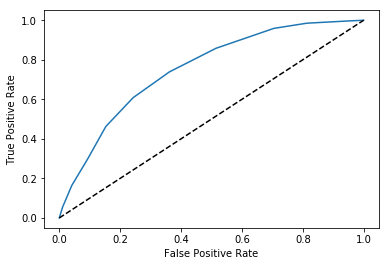

In [12]:
y_probas = bagging.predict_proba(X_test)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_probas[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [16]:
# AUC
predictions = bagging.predict(X_test)
print 'Area under the curve: {0:.3f}'.format(roc_auc_score(y_test.values,  predictions))
# Classification report
print classification_report(y_test.values, predictions)
# Determine log-loss
print 'Log loss: {}'.format(log_loss(y_test.values, y_probas[:,1]))
# Determine RMSE
print 'RMSE: {}'.format(mean_squared_error(y_test.values, y_probas[:,1]))

Area under the curve: 0.683
             precision    recall  f1-score   support

          0       0.66      0.76      0.70       268
          1       0.71      0.61      0.66       268

avg / total       0.69      0.68      0.68       536

Log loss: 0.826326573047
RMSE: 0.20322761194
